In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import audio_functions as af
import plot
import IPython
from scipy import signal

In [2]:
#Se crean los materiales para asignar al suelo y al resto de superficies
center_freqs = [125, 250, 500, 1000, 2000, 4000]
ground_dict = {"description":"gravel", "coeffs":[0.25, 0.60, 0.65, 0.70, 0.75, 0.80], "center_freqs":center_freqs}
no_ground_dict = {"description":"absolute absorbent", "coeffs":[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], "center_freqs":center_freqs}

ground = pra.Material(ground_dict)
no_ground = pra.Material(no_ground_dict)

#Se crea el diccionario donde se asignan los materiales a cada superficie
materials = {'east':no_ground, 'west':no_ground, 'north':no_ground, 'south':no_ground, 'ceiling':no_ground, 'floor':ground}

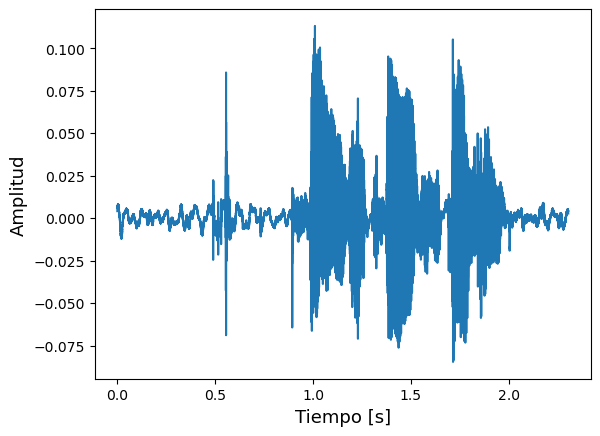

In [3]:
#Cargo el audio anecoico
audio, fs = af.load_audio("audios_anecoicos/p336_001.wav")
t_anecoico = np.arange(len(audio))/fs
signal = {"time vector":t_anecoico, "signal":audio, "label":"Audio Anecoico"}

plot.plot_signal(signal)
af.play_audio(audio, fs)

In [ ]:
#Determino las dimensiones para la simulación
room_dim = [1000, 1000, 100]

#Creo la habitación en formato shoebox
room = pra.ShoeBox(room_dim, fs=fs, max_order=1, materials=materials, air_absorption=True, temperature=20, humidity=40)

#Agrego fuente a la sala
room.add_source([400, 400, 2], signal=audio)

#Agrego array de mics a la sala
d_mic = 0.1
mic_array_loc = np.c_[[500, 500, 1.2], [500, 500+d_mic, 1.2], [500, 500+(d_mic*2), 1.2], [500, 500+(d_mic*3), 1.2]]
room.add_microphone_array(mic_array_loc)

fig, ax = room.plot(mic_marker_size=30, source_marker_size=30)
ax.set_xlim([0,1200])
ax.set_ylim([0,1200])
ax.set_zlim([0,150])


Figure(640x480)


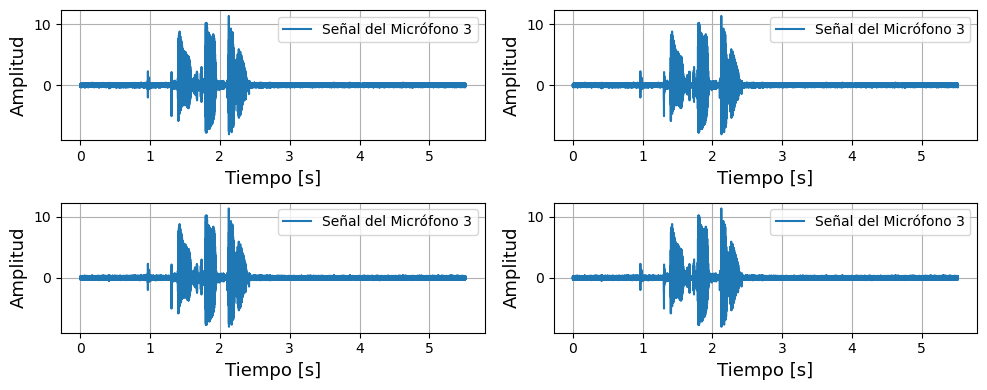

In [7]:
#Realizo la simulación
room.simulate(snr=20)

#Obtengo cada audio grabado en la sala
grabaciones = room.mic_array.signals
plots = []

for i in range(len(grabaciones)):
    mic_i = grabaciones[i]
    dur, t = af.get_audio_time_array(mic_i, fs)
    label = f"Señal del Micrófono {str(i)}"
    mic_plot = lambda : plot.plot_signal({"time vector":t, "signal":mic_i, "label":label}, legend=True, grid=True, show=False)
    plots.append(mic_plot)
    IPython.display.display(IPython.display.Audio(mic_i, rate = fs))
plot.multiplot(plots[0], plots[1], plots[2], plots[3], figsize=(10, 4), ncols=2)
    

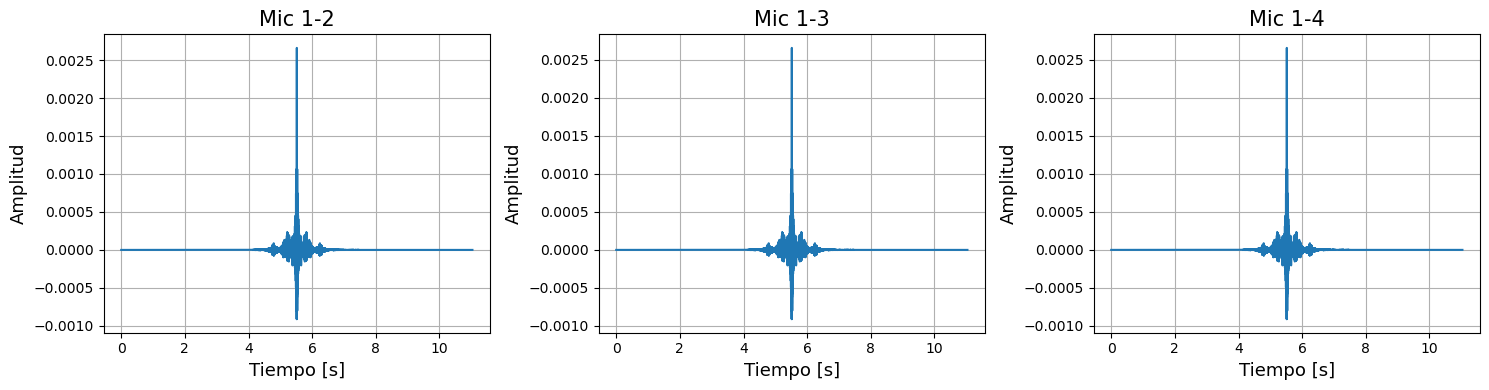

In [59]:
corr = []
for i in np.arange(len(grabaciones)-1):
    corr_class = signal.correlate(grabaciones[0], grabaciones[i+1])
    corr.append(corr_class)

_, t_corr = af.get_audio_time_array(corr[0], fs)

corr_1_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr[0]}, title="Mic 1-2", grid=True, show=False)
corr_2_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr[1]}, title="Mic 1-3", grid=True, show=False)
corr_3_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr[2]}, title="Mic 1-4", grid=True, show=False)

plot.multiplot(corr_1_pd, corr_2_pd, corr_3_pd, figsize=(15, 4), ncols=3)

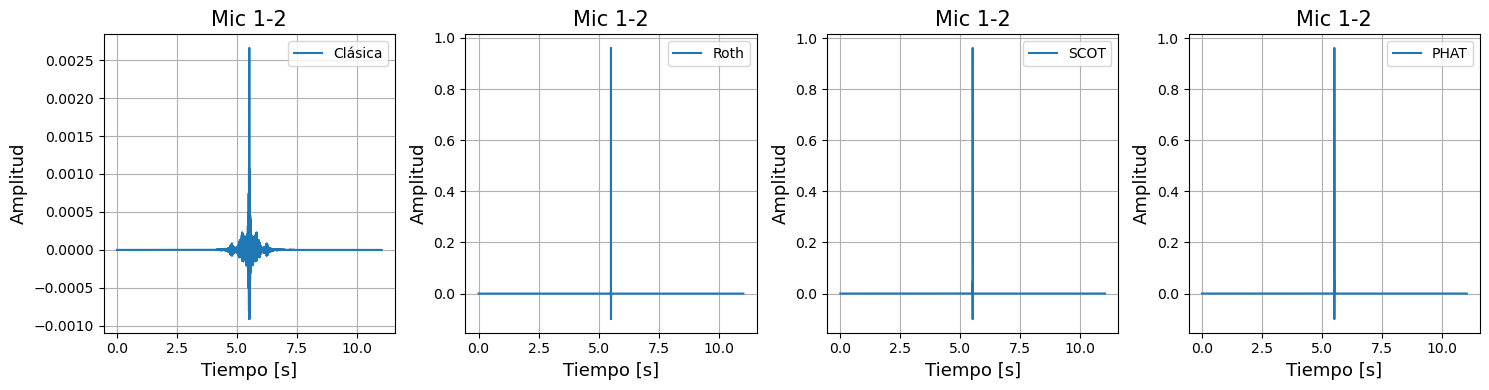

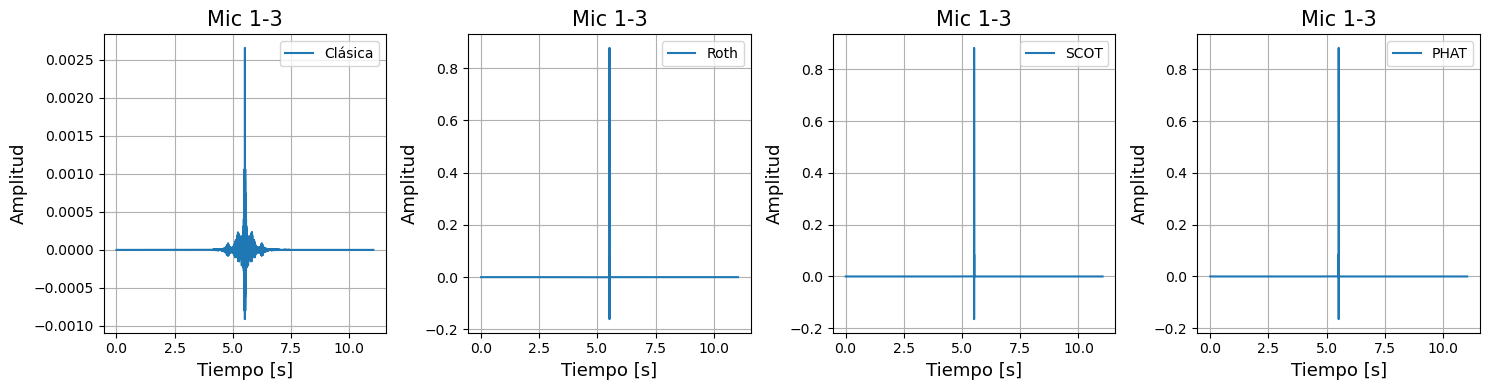

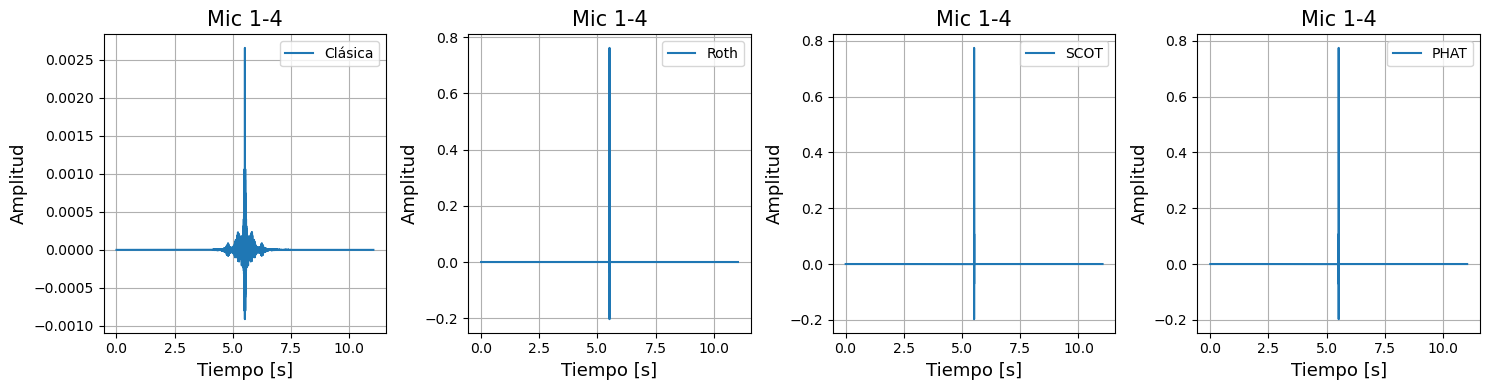

In [60]:
for i in np.arange(len(grabaciones)-1):
    corr_class = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs)
    corr_roth = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="ROTH")
    corr_scot = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="SCOT")
    corr_phat = af.cross_corr(grabaciones[0], grabaciones[i+1], fs=fs, mode="PHAT")
    _, t_corr = af.get_audio_time_array(corr_class, fs)
    corr_class_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_class, "label":"Clásica"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_roth_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_roth, "label":"Roth"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_scot_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_scot, "label":"SCOT"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)
    corr_phat_pd = lambda: plot.plot_signal({"time vector":t_corr, "signal":corr_phat, "label":"PHAT"}, legend=True, title=f"Mic 1-{i+2}", grid=True, show=False)

    plot.multiplot(corr_class_pd, corr_roth_pd, corr_scot_pd, corr_phat_pd, figsize=(15, 4), ncols=4)